In [17]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import math
import numpy as np
import matplotlib.colors as mc
import matplotlib.pyplot as plt
from copy import deepcopy
from utils import lists
DIRECTORY_PATH = '../data/tof_erda/raw/'
file_list = [os.path.join(DIRECTORY_PATH, file) for file in os.listdir(DIRECTORY_PATH) if file.endswith('.lst')]
chn = [2048,2048]

In [18]:
all_bhist_data = []  # To store results from all files
all_outLists = []    # To store outLists data for each file

for FILE_PATH in file_list:
    print(f'Processing file: {FILE_PATH}')
    header, events, timing = lists.lstRead(FILE_PATH)

    coin = [True, True, False, False, False, False, False, False]
    zdrop = True
    outLists = lists.getCoins(events, coin, zdrop)

    # Store outLists for each file for further processing
    all_outLists.append(outLists)

    binwidth = 2  # Set bin width
    bins_x = int(chn[0] / binwidth)
    bins_y = int(chn[1] / binwidth)

    inds_multi = [ind for ind in range(8) if coin[ind]]
    chmin = [0, 0]
    chmax = [chn[inds_multi[0]], chn[inds_multi[1]]]
    nbins = [chn[inds_multi[0]] + 1, chn[inds_multi[1]] + 1]
    nbins = [math.floor(nb / binwidth) for nb in nbins]
    bins = [np.linspace(chmin[0], chmax[0], nbins[0]), np.linspace(chmin[1], chmax[1], nbins[1])]

    print(f'channels used are {inds_multi}')
    print(f'number of bins = {nbins}')
    lhist, xed, yed = np.histogram2d(outLists[0], outLists[1], bins=bins)

    cut = 4
    pro_x = np.zeros(bins_x)
    pro_y = np.zeros(bins_y)

    for i in range(bins_x - 1):
        pro_x[i] = sum(lhist[i, :])
    for i in range(bins_y - 1):
        pro_y[i] = sum(lhist[:, i])

    for i in reversed(range(bins_x - 3)):
        if i == 3:
            bound_x = bins_x
            print('no good data found!')
            break
        if sum(pro_x[i - 2:i + 2]) > cut:
            bound_x = int(i * 1.1)
            if bound_x >= bins_x:
                bound_x = bins_x
            break

    for i in reversed(range(bins_y - 3)):
        if i == 3:
            bound_y = bins_y
            print('no good data found!')
            break
        if sum(pro_y[i - 2:i + 2]) > cut:
            bound_y = int(i * 1.1)
            if bound_y >= bins_y:
                bound_y = bins_y
            break

    print(f'auto-bound on X = {bound_x}')
    print(f'auto-bound on Y = {bound_y}')
    bhist = lhist[0:bound_x, 0:bound_y]

    thresh_x = 2
    thresh_y = 2

    bthist = deepcopy(bhist)
    bthist[0:bound_x, 0:thresh_y] = 0
    bthist[0:thresh_x, 0:bound_y] = 0

    prot_x = np.zeros(bound_x)
    prot_y = np.zeros(bound_y)
    for i in range(bound_x - 1):
        prot_x[i] = sum(bthist[i, :])
    for i in range(bound_y - 1):
        prot_y[i] = sum(bthist[:, i])

    all_bhist_data.append(bthist)


Processing file: ../data/tof_erda/raw/I_36MeV_SH2-12_S18.lst
channels used are [0, 1]
number of bins = [1024, 1024]
auto-bound on X = 716
auto-bound on Y = 1024
Processing file: ../data/tof_erda/raw/I_36MeV_SH2-14_Y-Deltt.lst
channels used are [0, 1]
number of bins = [1024, 1024]
auto-bound on X = 786
auto-bound on Y = 1024
Processing file: ../data/tof_erda/raw/I_36MeV_SH2-15_25B.lst
channels used are [0, 1]
number of bins = [1024, 1024]
auto-bound on X = 777
auto-bound on Y = 1024
Processing file: ../data/tof_erda/raw/I_36MeV_SH2-1_TiN-ref.lst
channels used are [0, 1]
number of bins = [1024, 1024]
auto-bound on X = 592
auto-bound on Y = 992
Processing file: ../data/tof_erda/raw/I_36MeV_SH2-2_Au-ref.lst
channels used are [0, 1]
number of bins = [1024, 1024]
auto-bound on X = 1024
auto-bound on Y = 1024
Processing file: ../data/tof_erda/raw/I_36MeV_SH2-3_SiC-ref.lst
channels used are [0, 1]
number of bins = [1024, 1024]
auto-bound on X = 465
auto-bound on Y = 625
Processing file: ../dat

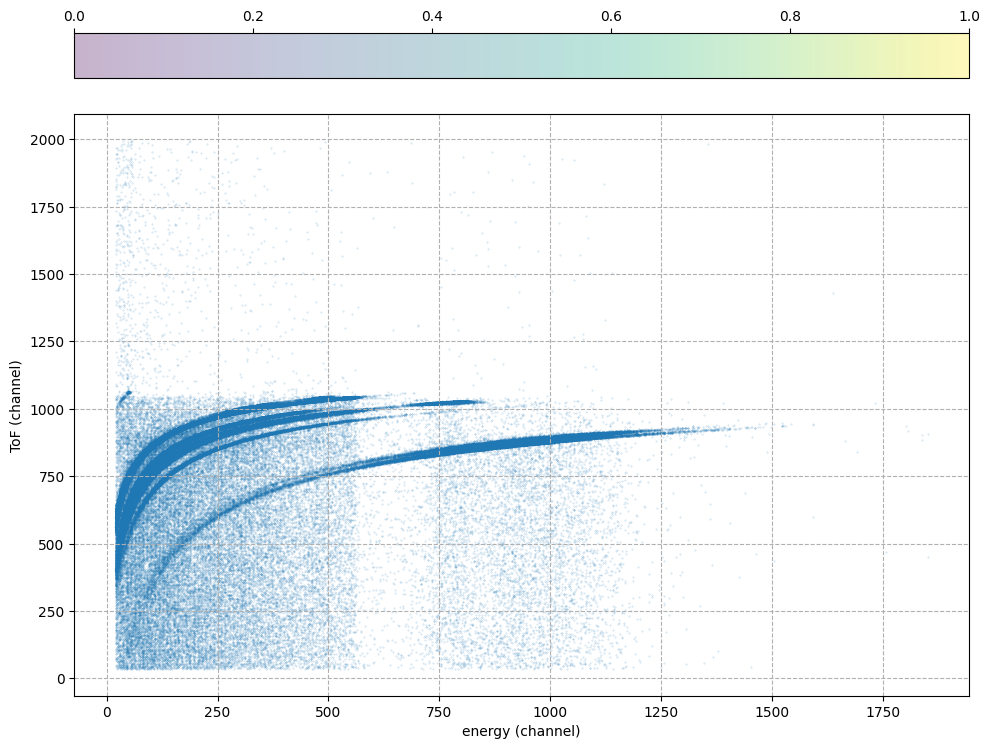

In [19]:
plt.figure(figsize=(10, 8))
plt.scatter(outLists[0], outLists[1], alpha=0.3, s=0.1)
plt.colorbar(location='top')
plt.grid(linestyle='--')
plt.xlabel('energy (channel)')
plt.ylabel('ToF (channel)')
plt.tight_layout()


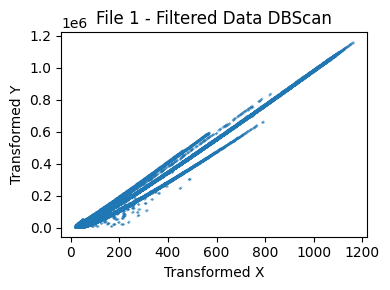

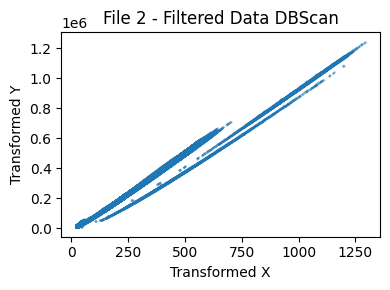

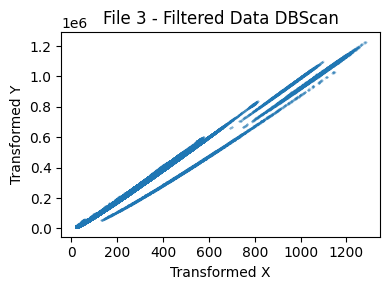

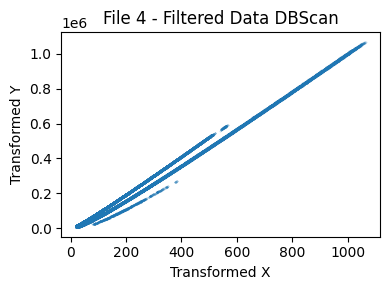

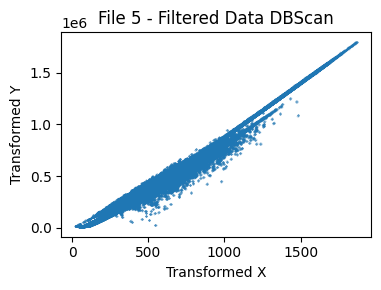

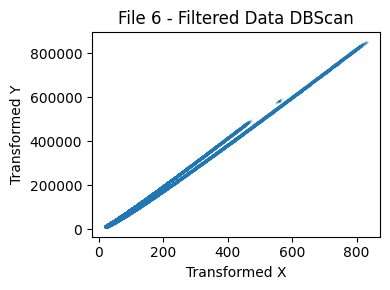

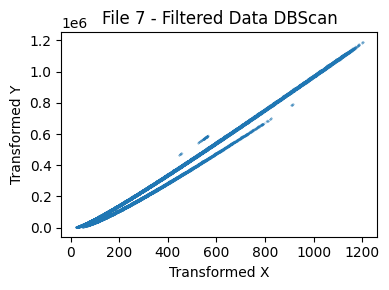

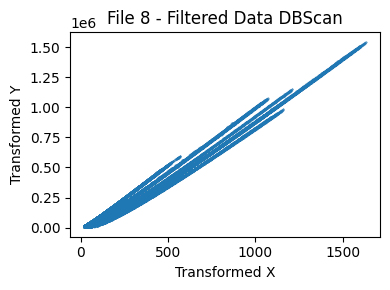

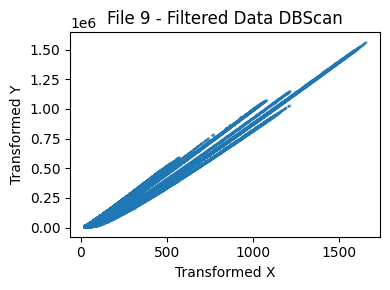

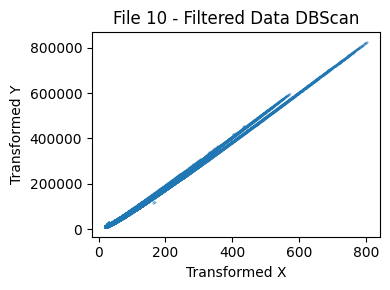

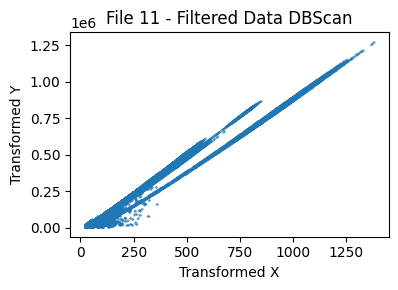

In [23]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import PolynomialFeatures

for i, (outLists, bthist) in enumerate(zip(all_outLists, all_bhist_data)):
    X = np.array([outLists[0], outLists[1]]).T 
    
    db = DBSCAN(eps=4, min_samples=10)
    db.fit(X)
    labels = db.labels_
    
    filtered_data = X[labels != -1]

    X_transformed = PolynomialFeatures(degree=2, include_bias=True).fit_transform(filtered_data)

    plt.figure(figsize=(4, 3))
    plt.scatter(X_transformed[:, 1], X_transformed[:, 4], alpha=0.3, s=0.1)
    plt.title(f'File {i + 1} - Filtered Data DBScan')
    plt.xlabel('Transformed X')
    plt.ylabel('Transformed Y')
    plt.tight_layout()
    plt.show()
